In [1]:
## create trajectories
import pyarrow.csv as pc
import pyarrow as pa

# Define the path to your CSV file
csv_file = "./data/cleaned/2.csv"  # Change this to your actual file path

# Read the CSV file into a PyArrow Table
try:
    table = pc.read_csv(csv_file)
except Exception as e:
    print(f"Error reading CSV file: {e}")
    exit()

# Convert to a pandas DataFrame
df = table.to_pandas()

# Display first few rows
print(df.head())
print(df.dtypes)

           MMSI  trip_id          trip_start            trip_end  \
0  0  111219518        1 2025-01-23 11:54:42 2025-01-23 13:35:50   
1  1  205482000        1 2025-01-29 19:26:21 2025-01-29 22:32:32   
2  3  209014000        1 2025-01-24 15:54:35 2025-01-24 19:36:45   
3  4  209014000        2 2025-01-24 20:42:35 2025-01-24 23:25:44   
4  5  209014000        3 2025-01-26 13:43:10 2025-01-27 04:48:30   

   trip_duration_sec  num_positions  trajectory_length_km  \
0             6068.0           4011            245.365185   
1            11171.0           1186             60.081535   
2            13330.0           1865             53.123009   
3             9789.0            172             42.907039   
4            54320.0           6827            172.992628   

   endpoint_distance_km  directness_ratio  ...  Aspect_Ratio  \
0              2.778663         88.303315  ...      0.250000   
1             58.911608          1.019859  ...      0.144444   
2             52.273276         

In [2]:
df.columns

df.to_csv("./data/swag.csv", index=False)

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# =============================================================================
# 2. Filter the Dataset by Ship Type
# =============================================================================

# Option A: Specify a list of ship types you want to include:
wanted_ship_types = ['Cargo', 'Tanker', 'Fishing', 'HSC', 'Passenger']  # <-- Change these as needed
df_filtered = df[df['Ship type'].isin(wanted_ship_types)]

# Option B: Alternatively, filter out ship types that have too few samples.
# Uncomment the following block if you prefer to use a minimum count threshold.
"""
min_samples = 50  # Set the minimum number of samples required for a ship type
ship_type_counts = df['Ship type'].value_counts()
ship_types_to_keep = ship_type_counts[ship_type_counts >= min_samples].index.tolist()
df_filtered = df[df['Ship type'].isin(ship_types_to_keep)]
"""

# Continue working with the filtered dataframe
df_clean = df_filtered.copy()

# =============================================================================
# 3. Preprocessing
# =============================================================================

# --- Step 1: Remove Unnecessary Columns ---
columns_to_drop = ["Name", "Callsign", "Destination", "MMSI", "trip_id", "trip_start", "trip_end"]
df_clean = df_clean.drop(columns=columns_to_drop)

# --- Step 2: Encode Categorical Variables ---
# Here, we include "Ship type" so that we can later recover the mapping.
cat_columns = ["Type of mobile", "Ship type", "Cargo type"]
le_dict = {}
for col in cat_columns:
    le = LabelEncoder()
    # Convert to string in case any of the labels are numbers
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    le_dict[col] = le

# --- Step 3: Check and Handle Missing Values ---
print("Missing values per column:")
print(df_clean.isna().sum())
df_clean = df_clean.dropna()  # Option: Drop rows with any missing values

# --- Step 4: Separate Features and Target BEFORE Scaling ---
# We want to predict "Ship type" so we separate it as the target.
y = df_clean["Ship type"]             # Target variable remains discrete
X = df_clean.drop(columns=["Ship type"])  # Features only

# --- Step 5: Feature Scaling (Apply ONLY on the Features) ---
scaler = StandardScaler()
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# --- Step 6: (Optional) Print the Mapping from Numeric Labels to Ship Types ---
# Retrieve the label encoder for "Ship type" and create a mapping dictionary.
le_ship_type = le_dict["Ship type"]
ship_type_mapping = dict(enumerate(le_ship_type.classes_))
print("\nMapping of numeric labels to original ship type names:")
print(ship_type_mapping)

# =============================================================================
# 4. Classification
# =============================================================================

# 1. Train-Test Split (using stratification to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nTraining set class distribution:")
print(y_train.value_counts())
print("\nTest set class distribution:")
print(y_test.value_counts())

# 2. Apply SMOTE to the Training Set (to address class imbalance)
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("\nAfter applying SMOTE, training set class distribution:")
print(pd.Series(y_train_smote).value_counts())

# 3. Define the Classifiers to Evaluate
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear')
}

# 4. Define a Helper Function for Evaluation
def evaluate_classifier(model, X_eval, y_eval, classifier_name):
    """
    Evaluate a classifier on the evaluation set and print key metrics.
    Returns a dictionary with the scores.
    """
    y_pred = model.predict(X_eval)
    
    acc  = accuracy_score(y_eval, y_pred)
    prec = precision_score(y_eval, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_eval, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_eval, y_pred, average='macro', zero_division=0)
    
    print(f"\nClassifier: {classifier_name}")
    print(f"Accuracy:         {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro):    {rec:.4f}")
    print(f"F1 Score (macro):  {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_eval, y_pred, zero_division=0))
    print("-"*50)
    
    return {
        "Classifier": classifier_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    }

# 5. Train and Evaluate the Models
results = []

print("\n=== Evaluating Models WITHOUT SMOTE ===")
for name, clf in classifiers.items():
    # Train on the original (non-SMOTE) training data.
    clf.fit(X_train, y_train)
    result = evaluate_classifier(clf, X_test, y_test, name + " (Original)")
    results.append(result)

print("\n=== Evaluating Models WITH SMOTE ===")
for name, clf in classifiers.items():
    # Train on the SMOTE-augmented training data.
    clf.fit(X_train_smote, y_train_smote)
    result = evaluate_classifier(clf, X_test, y_test, name + " (SMOTE)")
    results.append(result)

# 6. Summarize the Results in a DataFrame
results_df = pd.DataFrame(results)
print("\nSummary of classifier performance:")
print(results_df)

# =============================================================================
# (Optional) Converting Predictions Back to Original Ship Type Names
# =============================================================================
# If you later obtain predictions in numeric form (e.g., from any classifier),
# you can convert them back to the original ship type names like this:
#
# Example:
# y_pred_numeric = classifiers["Random Forest"].predict(X_test)
# y_pred_original = le_ship_type.inverse_transform(y_pred_numeric)
# print("\nPredictions in original ship type names:")
# print(y_pred_original)


Missing values per column:
                         0
trip_duration_sec        0
num_positions            0
trajectory_length_km     0
endpoint_distance_km     0
directness_ratio         0
min_lat                  0
max_lat                  0
min_lon                  0
max_lon                  0
lat_span                 0
lon_span                 0
sog_min                  0
sog_max                  0
sog_mean                 0
sog_median               0
sog_std                  0
cog_min                  0
cog_max                  0
cog_mean                 0
cog_median               0
cog_std                  0
init_cos                 0
init_sin                 0
Naive_Perimeter          1
Naive_Area               1
Aspect_Ratio             1
Shape_Complexity         1
Bridge_Position_Ratio    2
Type of mobile           0
Ship type                0
Cargo type               0
total_km2                0
dtype: int64

Mapping of numeric labels to original ship type names:
{0: 'Cargo', 

In [3]:
import pandas as pd
import numpy as np

# Preprocessing and evaluation libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# For SMOTE to address class imbalance
from imblearn.over_sampling import SMOTE

# =============================================================================
# 1. Data Preparation and Preprocessing
# =============================================================================
# Assume that the original dataframe "df" is already loaded in your environment.
# For example, you might have read it from a CSV:
# df = pd.read_csv("your_data.csv")

# ----- Filter the Dataset by Ship Type -----
# Here we choose specific ship types to include.
wanted_ship_types = ['Cargo', 'Tanker', 'Fishing', 'HSC', 'Passenger']  # <-- Change these as needed
df_filtered = df[df['Ship type'].isin(wanted_ship_types)]

# Make a copy of the filtered dataframe
df_clean = df_filtered.copy()

# ----- Remove Unnecessary Columns -----
columns_to_drop = ["Name", "Callsign", "Destination", "MMSI", "trip_id", "trip_start", "trip_end"]
df_clean = df_clean.drop(columns=columns_to_drop)

# ----- Encode Categorical Variables -----
# We encode columns such as "Ship type" and other categorical features.
cat_columns = ["Type of mobile", "Ship type", "Cargo type"]
le_dict = {}
for col in cat_columns:
    le = LabelEncoder()
    # Convert to string in case any labels are numeric already
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    le_dict[col] = le

# ----- Check and Handle Missing Values -----
print("Missing values per column:")
print(df_clean.isna().sum())
# Here we simply drop rows with any missing values.
df_clean = df_clean.dropna()

# ----- Separate Features and Target -----
# We want to predict "Ship type", so we separate it as the target.
y = df_clean["Ship type"]             # Target variable (numeric encoding of ship type)
X = df_clean.drop(columns=["Ship type"])  # All other columns are features

# ----- Feature Scaling -----
# Scale numeric features so that each feature contributes equally.
scaler = StandardScaler()
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# ----- (Optional) Print the Mapping of Labels to Original Ship Types -----
le_ship_type = le_dict["Ship type"]
ship_type_mapping = dict(enumerate(le_ship_type.classes_))
print("\nMapping of numeric labels to original ship type names:")
print(ship_type_mapping)

# =============================================================================
# 2. Split Data into Training and Test Sets
# =============================================================================
# We use stratification to ensure that the class distribution is similar in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nTraining set class distribution:")
print(y_train.value_counts())
print("\nTest set class distribution:")
print(y_test.value_counts())

# =============================================================================
# 3. Define a Helper Function for Model Evaluation
# =============================================================================
def evaluate_classifier(model, X_eval, y_eval, classifier_name):
    """
    Evaluate a classifier on the given evaluation set and print key metrics.
    This function prints accuracy, macro-averaged precision, recall, F1-score,
    and a detailed classification report.
    
    Parameters:
        model: A trained model that supports the .predict() method.
        X_eval: The feature set for evaluation.
        y_eval: The true labels.
        classifier_name: String name for the classifier (used in print statements).
    
    Returns:
        A dictionary containing the evaluation metrics.
    """
    y_pred = model.predict(X_eval)
    
    acc  = accuracy_score(y_eval, y_pred)
    prec = precision_score(y_eval, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_eval, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_eval, y_pred, average='macro', zero_division=0)
    
    print(f"\nClassifier: {classifier_name}")
    print(f"Accuracy:         {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro):    {rec:.4f}")
    print(f"F1 Score (macro):  {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_eval, y_pred, zero_division=0))
    print("-"*50)
    
    return {
        "Classifier": classifier_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    }

# =============================================================================
# 4. Setup Cross-Validation
# =============================================================================
# We use StratifiedKFold to ensure each fold has a similar class distribution.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =============================================================================
# 5. Evaluate Default Models using Cross-Validation on the Training Set
# =============================================================================
# We define a dictionary of default models.
default_models = {
    "GaussianNB": GaussianNB(),
    "SVM": SVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

print("\n=== CROSS-VALIDATION SCORES (DEFAULT PARAMETERS) on Original Training Data ===")
for name, model in default_models.items():
    # Using accuracy as the scoring metric; you could also try others.
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"{name} - CV Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# =============================================================================
# 6. Train Default Models on the Entire Training Set and Evaluate on the Test Set
# =============================================================================
results = []  # To store results for summary

print("\n=== TEST SET EVALUATION (DEFAULT MODELS on Original Data) ===")
for name, model in default_models.items():
    # Train the model on the full training data
    model.fit(X_train, y_train)
    # Evaluate on the test set and record the results
    result = evaluate_classifier(model, X_test, y_test, name + " (Default)")
    results.append(result)

# =============================================================================
# 7. Hyperparameter Tuning via GridSearchCV (Using Cross-Validation)
# =============================================================================
# We tune only SVM, Decision Tree, and Random Forest.
# Grid search will try different combinations of parameters and choose the best one based on cross-validation performance.

# --- Define parameter grids for each model ---
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

param_grid_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# --- Setup GridSearchCV for each tuned model ---
grid_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=cv, scoring='accuracy', n_jobs=-1)
grid_dt  = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=cv, scoring='accuracy', n_jobs=-1)
grid_rf  = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=cv, scoring='accuracy', n_jobs=-1)

print("\n=== HYPERPARAMETER TUNING (Using GridSearchCV on Original Training Data) ===")

# --- SVM Tuning ---
grid_svm.fit(X_train, y_train)
print("Best parameters for SVM:", grid_svm.best_params_)
print("Best cross-validation accuracy for SVM: {:.4f}".format(grid_svm.best_score_))

# --- Decision Tree Tuning ---
grid_dt.fit(X_train, y_train)
print("Best parameters for Decision Tree:", grid_dt.best_params_)
print("Best cross-validation accuracy for Decision Tree: {:.4f}".format(grid_dt.best_score_))

# --- Random Forest Tuning ---
grid_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_rf.best_params_)
print("Best cross-validation accuracy for Random Forest: {:.4f}".format(grid_rf.best_score_))

# Store the best estimators from grid search in a dictionary.
tuned_models = {
    "SVM Tuned": grid_svm.best_estimator_,
    "Decision Tree Tuned": grid_dt.best_estimator_,
    "Random Forest Tuned": grid_rf.best_estimator_
}

# =============================================================================
# 8. Evaluate Tuned Models on the Test Set
# =============================================================================
print("\n=== TEST SET EVALUATION (TUNED MODELS on Original Data) ===")
for name, model in tuned_models.items():
    # It is good practice to re-fit the best_estimator_ on the full training set
    model.fit(X_train, y_train)
    result = evaluate_classifier(model, X_test, y_test, name)
    results.append(result)

# =============================================================================
# 9. Now, Repeat the Experiments on SMOTE-Augmented Training Data
# =============================================================================
# SMOTE is used to generate synthetic samples of the minority classes so that classes are balanced.
smote = SMOTE(random_state=42, k_neighbors=1)  # k_neighbors can be tuned if needed
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("\nAfter applying SMOTE, training set class distribution:")
print(pd.Series(y_train_smote).value_counts())

# ---- 9a. Evaluate Default Models with SMOTE ----
print("\n=== CROSS-VALIDATION SCORES (DEFAULT PARAMETERS) on SMOTE Training Data ===")
for name, model in default_models.items():
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=cv, scoring='accuracy')
    print(f"{name} - CV Accuracy (SMOTE): {scores.mean():.4f} (+/- {scores.std():.4f})")

print("\n=== TEST SET EVALUATION (DEFAULT MODELS on SMOTE Data) ===")
for name, model in default_models.items():
    model.fit(X_train_smote, y_train_smote)
    result = evaluate_classifier(model, X_test, y_test, name + " (Default + SMOTE)")
    results.append(result)

# ---- 9b. Hyperparameter Tuning on SMOTE Data ----
print("\n=== HYPERPARAMETER TUNING (Using GridSearchCV on SMOTE Training Data) ===")

# SVM Tuning with SMOTE
grid_svm_smote = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=cv, scoring='accuracy', n_jobs=-1)
grid_svm_smote.fit(X_train_smote, y_train_smote)
print("Best parameters for SVM with SMOTE:", grid_svm_smote.best_params_)
print("Best CV accuracy for SVM with SMOTE: {:.4f}".format(grid_svm_smote.best_score_))

# Decision Tree Tuning with SMOTE
grid_dt_smote = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=cv, scoring='accuracy', n_jobs=-1)
grid_dt_smote.fit(X_train_smote, y_train_smote)
print("Best parameters for Decision Tree with SMOTE:", grid_dt_smote.best_params_)
print("Best CV accuracy for Decision Tree with SMOTE: {:.4f}".format(grid_dt_smote.best_score_))

# Random Forest Tuning with SMOTE
grid_rf_smote = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=cv, scoring='accuracy', n_jobs=-1)
grid_rf_smote.fit(X_train_smote, y_train_smote)
print("Best parameters for Random Forest with SMOTE:", grid_rf_smote.best_params_)
print("Best CV accuracy for Random Forest with SMOTE: {:.4f}".format(grid_rf_smote.best_score_))

# Save the best estimators for SMOTE-tuned models
tuned_models_smote = {
    "SVM Tuned + SMOTE": grid_svm_smote.best_estimator_,
    "Decision Tree Tuned + SMOTE": grid_dt_smote.best_estimator_,
    "Random Forest Tuned + SMOTE": grid_rf_smote.best_estimator_
}

print("\n=== TEST SET EVALUATION (TUNED MODELS on SMOTE Data) ===")
for name, model in tuned_models_smote.items():
    model.fit(X_train_smote, y_train_smote)
    result = evaluate_classifier(model, X_test, y_test, name)
    results.append(result)

# =============================================================================
# 10. Summarize All Results
# =============================================================================
results_df = pd.DataFrame(results)
print("\nSummary of classifier performance across all experiments:")
print(results_df)

Missing values per column:
                         0
trip_duration_sec        0
num_positions            0
trajectory_length_km     0
endpoint_distance_km     0
directness_ratio         0
min_lat                  0
max_lat                  0
min_lon                  0
max_lon                  0
lat_span                 0
lon_span                 0
sog_min                  0
sog_max                  0
sog_mean                 0
sog_median               0
sog_std                  0
cog_min                  0
cog_max                  0
cog_mean                 0
cog_median               0
cog_std                  0
init_cos                 0
init_sin                 0
Naive_Perimeter          1
Naive_Area               1
Aspect_Ratio             1
Shape_Complexity         1
Bridge_Position_Ratio    2
Type of mobile           0
Ship type                0
Cargo type               0
total_km2                0
dtype: int64

Mapping of numeric labels to original ship type names:
{0: 'Cargo', 

/tmp/ipykernel_1009743/3679079925.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


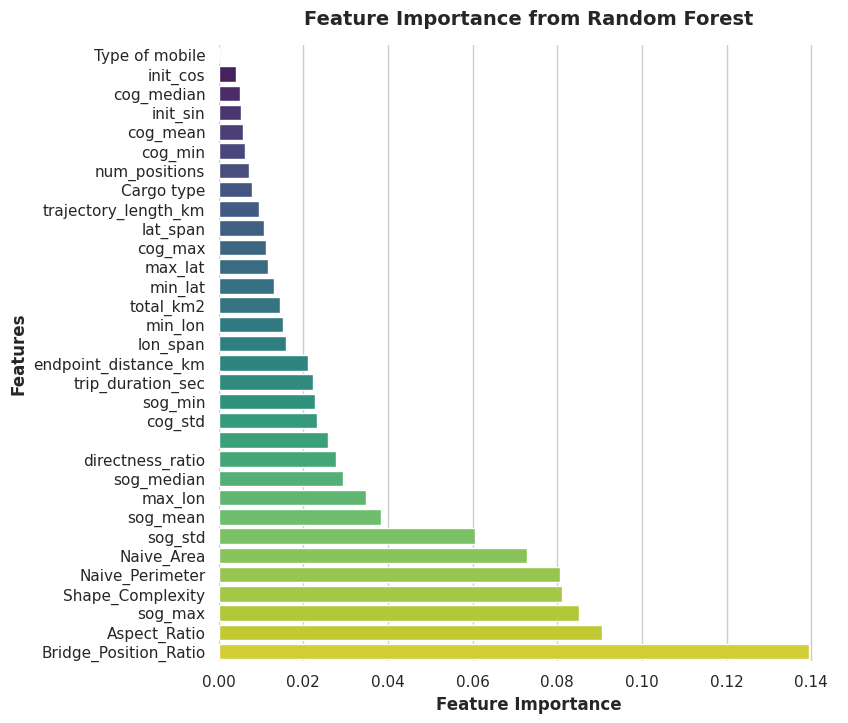

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assume "model_rf" is a trained Random Forest classifier
model_rf = tuned_models_smote["Random Forest Tuned + SMOTE"]

# Ensure the model is fitted
model_rf.fit(X_train_smote, y_train_smote)

# Extract feature importances
importances = model_rf.feature_importances_
feature_names = X_train.columns  # assuming X_train is a DataFrame

# Create DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)  # Ascending for horizontal barplot

# Plot feature importance with enhanced styling
plt.figure(figsize=(8, 8))
sns.set_theme(style="whitegrid")  # Modern, clean look

ax = sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df, 
    palette='viridis'  # Use a visually appealing colormap
)

# Add labels and title with improved styling
ax.set_xlabel("Feature Importance", fontsize=12, fontweight="bold")
ax.set_ylabel("Features", fontsize=12, fontweight="bold")
ax.set_title("Feature Importance from Random Forest", fontsize=14, fontweight="bold", pad=15)

# Remove spines for a cleaner look
sns.despine(left=True, bottom=True)

# Save and show plot
plt.savefig("feature_importance_rf.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_1009743/1105553059.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


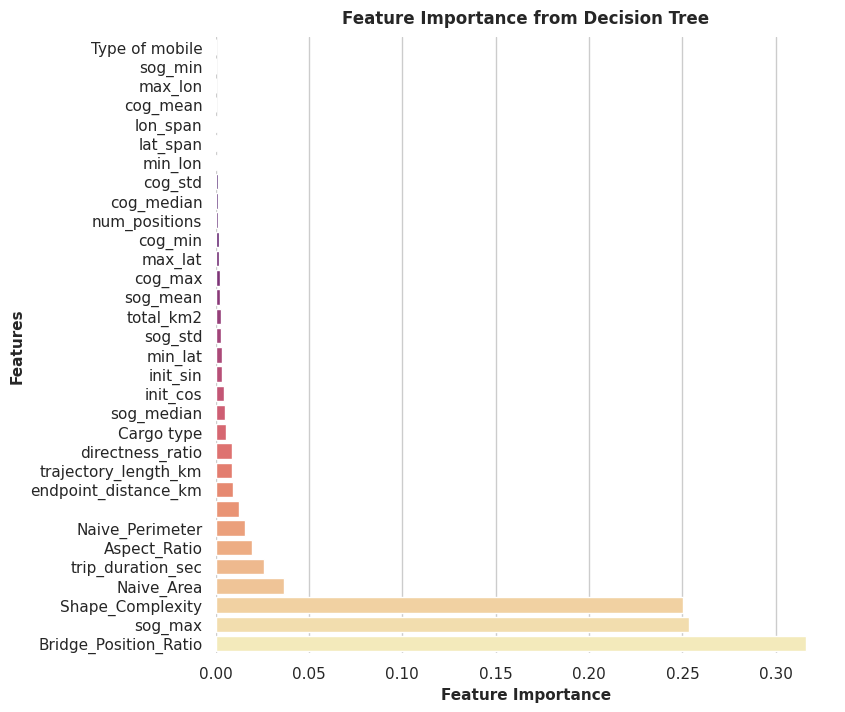

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assume "model_dt" is the tuned Decision Tree from the SMOTE experiment
model_dt = tuned_models_smote["Decision Tree Tuned + SMOTE"]
model_dt.fit(X_train_smote, y_train_smote)

# Extract feature importances
importances_dt = model_dt.feature_importances_
importance_dt_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_dt})
importance_dt_df = importance_dt_df.sort_values(by='Importance', ascending=True)  # Sort for better visualization

# Plot feature importance with enhanced styling
plt.figure(figsize=(8, 8))
sns.set_theme(style="whitegrid")  # Modern, clean look

ax = sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_dt_df, 
    palette='magma'  # Use a visually appealing colormap
)

# Add labels and title with improved styling
ax.set_xlabel("Feature Importance", fontsize=11, fontweight="bold")
ax.set_ylabel("Features", fontsize=11, fontweight="bold")
ax.set_title("Feature Importance from Decision Tree", fontsize=12, fontweight="bold", pad=10)

# Remove spines for a cleaner look
sns.despine(left=True, bottom=True)
plt.savefig("feature_importance_dt.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()


/tmp/ipykernel_1009743/3272202184.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


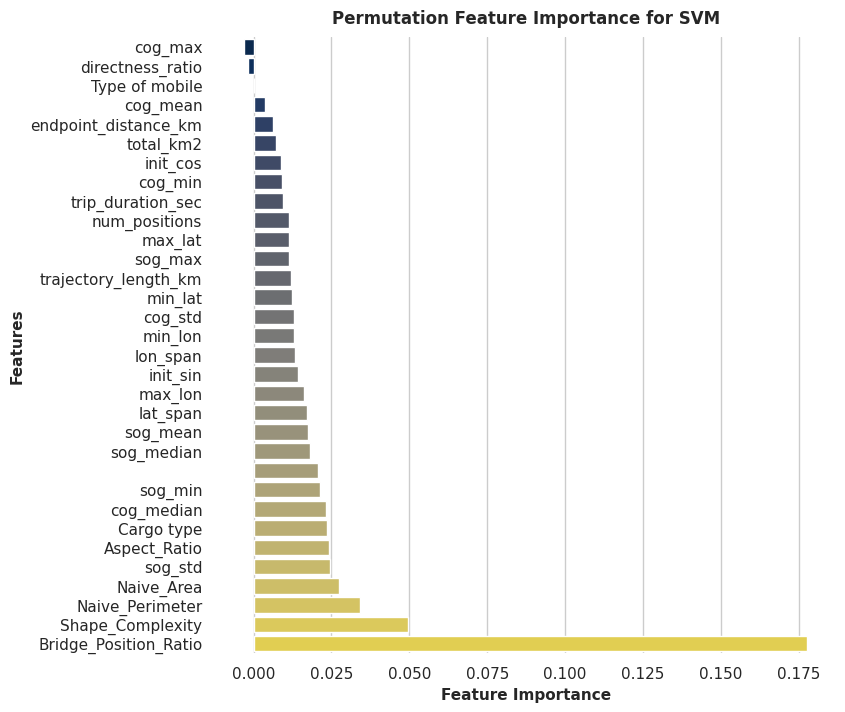

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.inspection import permutation_importance

# Assume "model_svm" is your SVM model (tuned or default)
model_svm = tuned_models_smote["SVM Tuned + SMOTE"]
model_svm.fit(X_train_smote, y_train_smote)

# Calculate permutation importance on the test set
perm_importance = permutation_importance(model_svm, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=42)

# Create DataFrame for visualization
importance_svm_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=True)  # Sort ascending for horizontal barplot

# Plot feature importance with enhanced styling
plt.figure(figsize=(8, 8))
sns.set_theme(style="whitegrid")  # Modern, clean look

ax = sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_svm_df, 
    palette='cividis'  # Use a visually appealing colormap
)

# Add labels and title with improved styling
ax.set_xlabel("Feature Importance", fontsize=11, fontweight="bold")
ax.set_ylabel("Features", fontsize=11, fontweight="bold")
ax.set_title("Permutation Feature Importance for SVM", fontsize=12, fontweight="bold", pad=10)

# Remove spines for a cleaner look
sns.despine(left=True, bottom=True)
plt.savefig("feature_importance_svm.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()


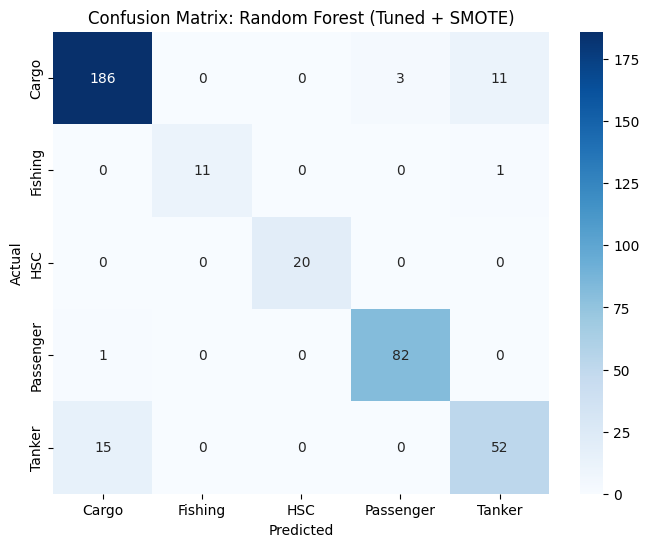

In [8]:
from sklearn.metrics import confusion_matrix

# Let’s use our tuned Random Forest model as an example:
y_pred = model_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(ship_type_mapping.values()),
            yticklabels=list(ship_type_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix: Random Forest (Tuned + SMOTE)')
plt.show()





First 5 rows of the DataFrame:


,,MMSI,trip_id,trip_start,trip_end,trip_duration_sec,num_positions,trajectory_length_km,endpoint_distance_km,directness_ratio,...,Aspect_Ratio,Shape_Complexity,Bridge_Position_Ratio,Type of mobile,Ship type,Cargo type,Callsign,Name,Destination,total_km2
0,0,111219518,1,2025-01-23 11:54:42,2025-01-23 13:35:50,6068.0,4011,245.365185,2.778663,88.303315,...,0.250000,6.250000,0.050000,Class A,,,0,,SEARCH AND RESCUE,3496.048806
1,1,205482000,1,2025-01-29 19:26:21,2025-01-29 22:32:32,11171.0,1186,60.081535,58.911608,1.019859,...,0.144444,9.067521,0.833333,Class A,Cargo,No additional information,ONEO,FAST SUS,PLSZZ,1745.507422
2,3,209014000,1,2025-01-24 15:54:35,2025-01-24 19:36:45,13330.0,1865,53.123009,52.273276,1.016256,...,0.136364,9.469697,0.863636,Class A,Cargo,,P3ME6,RIX EMERALD,DESTL,1343.271526
3,4,209014000,2,2025-01-24 20:42:35,2025-01-24 23:25:44,9789.0,172,42.907039,42.860129,1.001094,...,0.136364,9.469697,0.863636,Class A,Cargo,,P3ME6,RIX EMERALD,DESTL,787.061562
4,5,209014000,3,2025-01-26 13:43:10,2025-01-27 04:48:30,54320.0,6827,172.992628,163.346890,1.059051,...,0.136364,9.469697,0.863636,Class A,Cargo,,P3ME6,RIX EMERALD,SEAHU,7091.762465



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype        
---  ------                 --------------  -----        
 0                          2101 non-null   int64        
 1   MMSI                   2101 non-null   int64        
 2   trip_id                2101 non-null   int64        
 3   trip_start             2101 non-null   datetime64[s]
 4   trip_end               2101 non-null   datetime64[s]
 5   trip_duration_sec      2101 non-null   float64      
 6   num_positions          2101 non-null   int64        
 7   trajectory_length_km   2101 non-null   float64      
 8   endpoint_distance_km   2101 non-null   float64      
 9   directness_ratio       2101 non-null   float64      
 10  min_lat                2101 non-null   float64      
 11  max_lat                2101 non-null   float64      
 12  min_lon                2101 non-null   float64      
 13  m

None


Summary statistics for numerical features:


,,MMSI,trip_id,trip_start,trip_end,trip_duration_sec,num_positions,trajectory_length_km,endpoint_distance_km,directness_ratio,...,cog_median,cog_std,init_cos,init_sin,Naive_Perimeter,Naive_Area,Aspect_Ratio,Shape_Complexity,Bridge_Position_Ratio,total_km2
count,2101.000000,2.101000e+03,2101.000000,2101,2101,2101.00000,2101.00000,2101.000000,2101.000000,2101.000000,...,2101.000000,2101.000000,2101.000000,2101.000000,2091.000000,2091.000000,2091.000000,2091.000000,2090.000000,2101.000000
mean,1156.072822,2.849797e+08,3.147549,2025-01-26 21:51:42,2025-01-27 05:52:29,28847.76773,4366.49643,161.382086,145.375714,68.698921,...,173.614208,25.482862,0.171673,0.046747,313.538977,3436.280727,0.170524,8.436175,0.614576,10070.847565
min,0.000000,1.112195e+08,1.000000,2025-01-23 00:00:00,2025-01-23 00:08:27,433.00000,54.00000,4.042787,0.006318,1.000011,...,2.200000,0.268032,-1.000000,-0.999918,34.000000,56.000000,0.069364,4.500000,0.030303,3.020867
25%,594.000000,2.190281e+08,1.000000,2025-01-24 22:26:05,2025-01-25 06:07:16,13199.00000,1865.00000,73.377040,64.835767,1.012704,...,75.200000,9.555803,-0.946072,-0.170748,206.000000,1170.000000,0.141176,8.037121,0.218341,1624.462863
50%,1164.000000,2.495750e+08,1.000000,2025-01-26 21:21:56,2025-01-27 05:13:31,28580.00000,3985.00000,168.774372,151.865668,1.026762,...,185.100000,13.434254,0.731055,0.000000,294.000000,2546.000000,0.153846,8.653846,0.805000,6407.673032
75%,1724.000000,2.773910e+08,3.000000,2025-01-29 00:13:39,2025-01-29 07:50:44,40010.00000,6062.00000,239.461561,229.247672,1.082978,...,245.500000,23.757967,1.000000,0.328302,426.000000,5208.000000,0.170455,9.224510,0.863636,17002.936599
max,2288.000000,6.681163e+08,22.000000,2025-01-30 23:44:21,2025-01-30 23:59:58,309290.00000,43564.00000,709.430181,257.461902,73800.431209,...,356.700000,168.875031,1.000000,1.000000,920.000000,24339.000000,0.500000,16.486031,1.000000,28990.176755
std,662.976702,1.103748e+08,3.786081,NaN,NaN,21819.30330,3520.09052,88.696617,87.053754,1729.256891,...,93.411673,31.453624,0.891559,0.417045,145.170620,2925.227504,0.056617,1.239281,0.318948,9664.460565



Summary statistics for categorical features:


,Type of mobile,Ship type,Cargo type,Callsign,Name,Destination
count,2101,2101,2101,2101,2101,2101
unique,1,16,7,1109,1100,730
top,Class A,Cargo,,SIEB,SKANE,SEMMA<>DETRV
freq,2101,999,1351,22,22,45


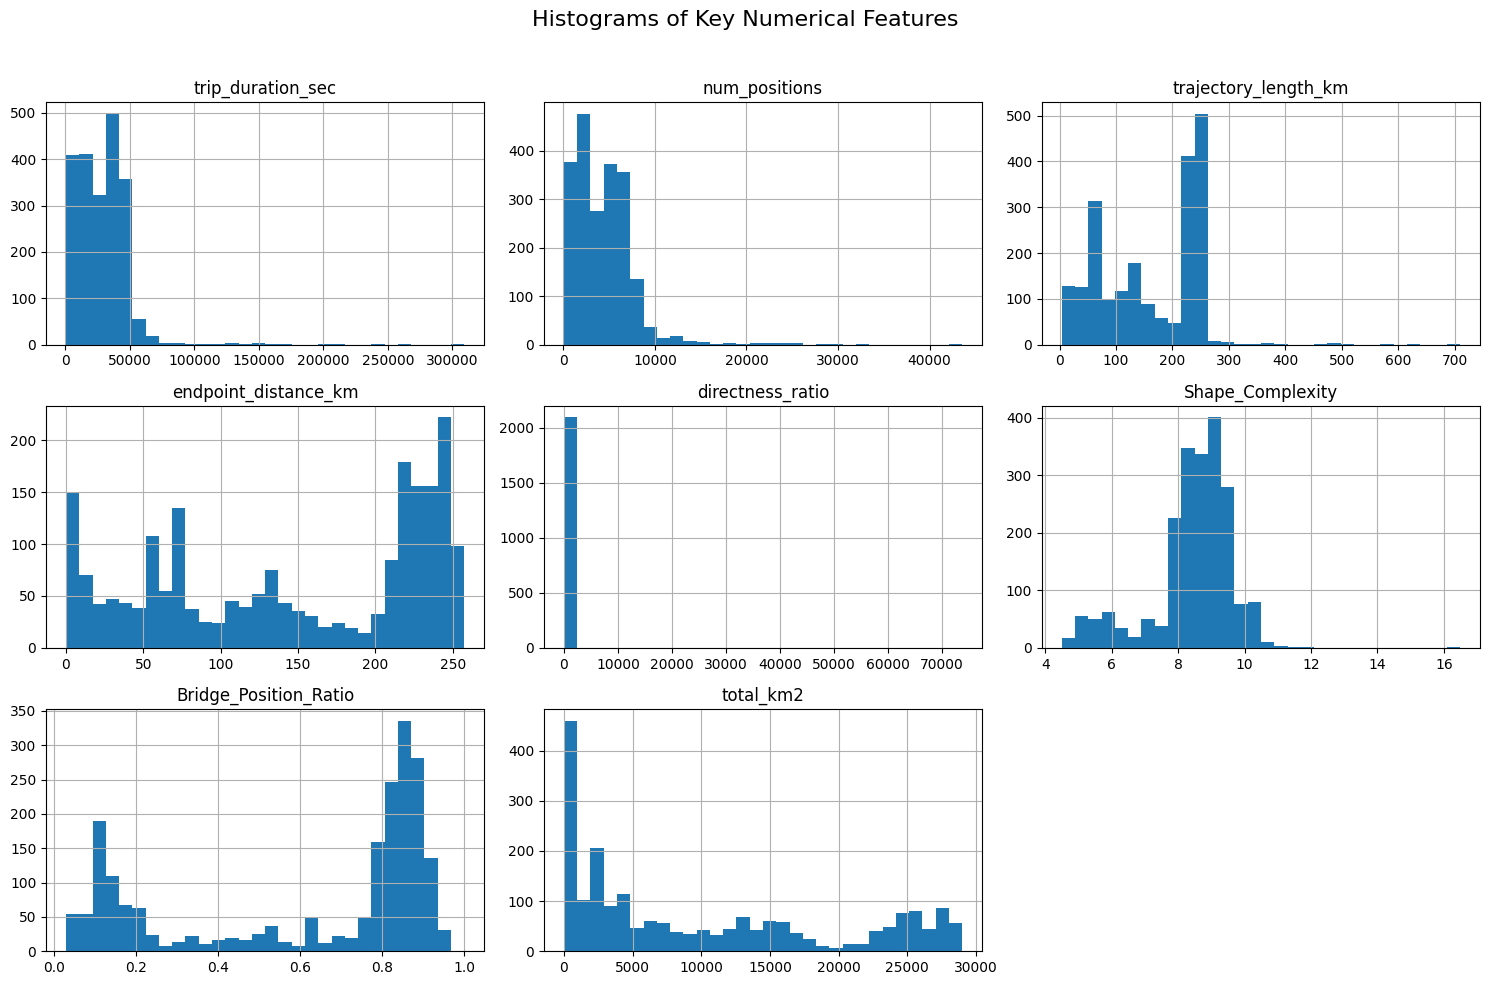

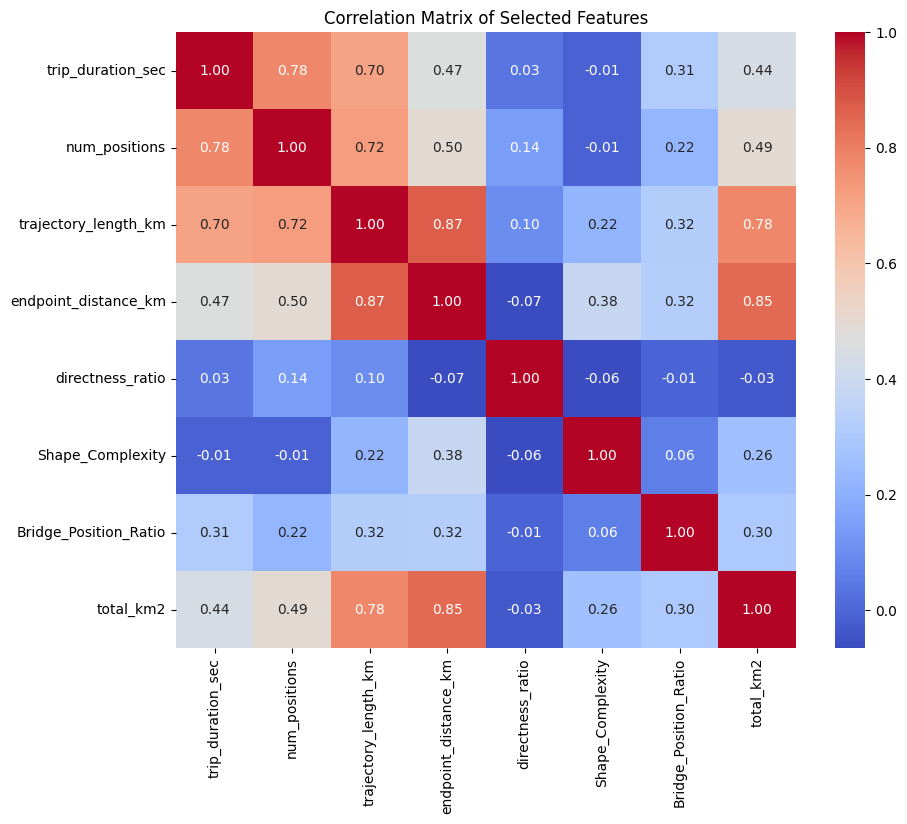

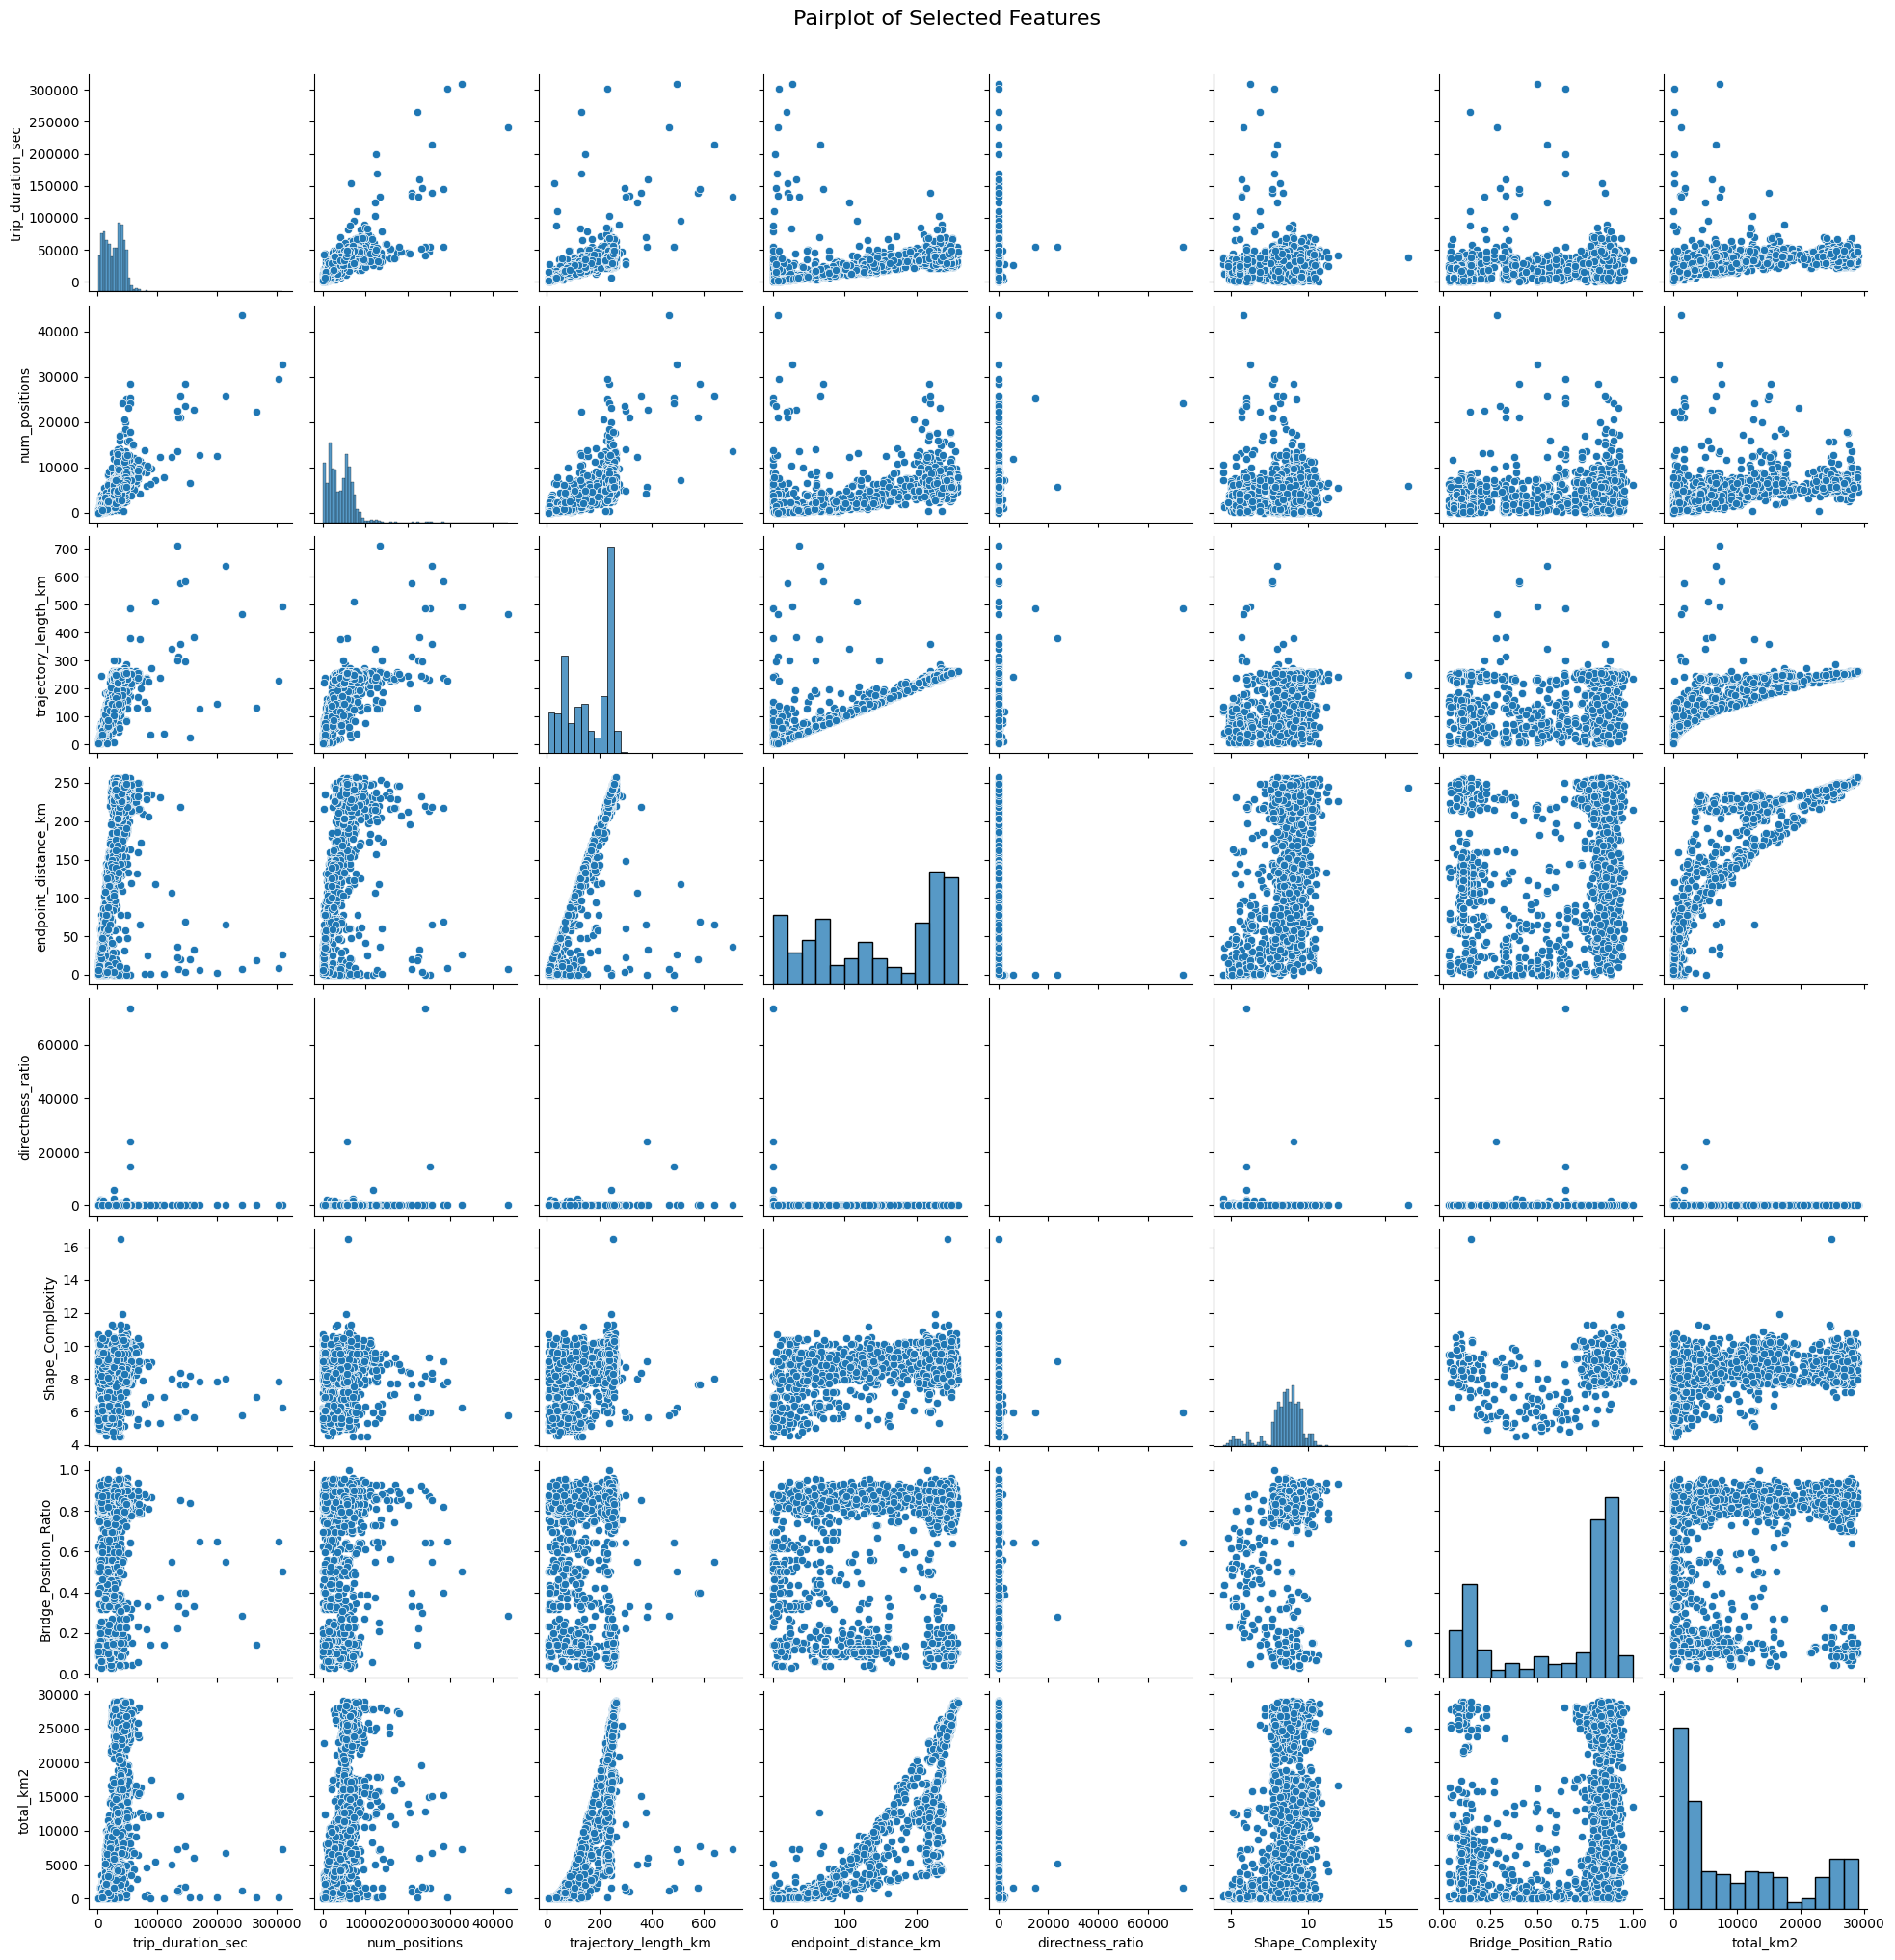

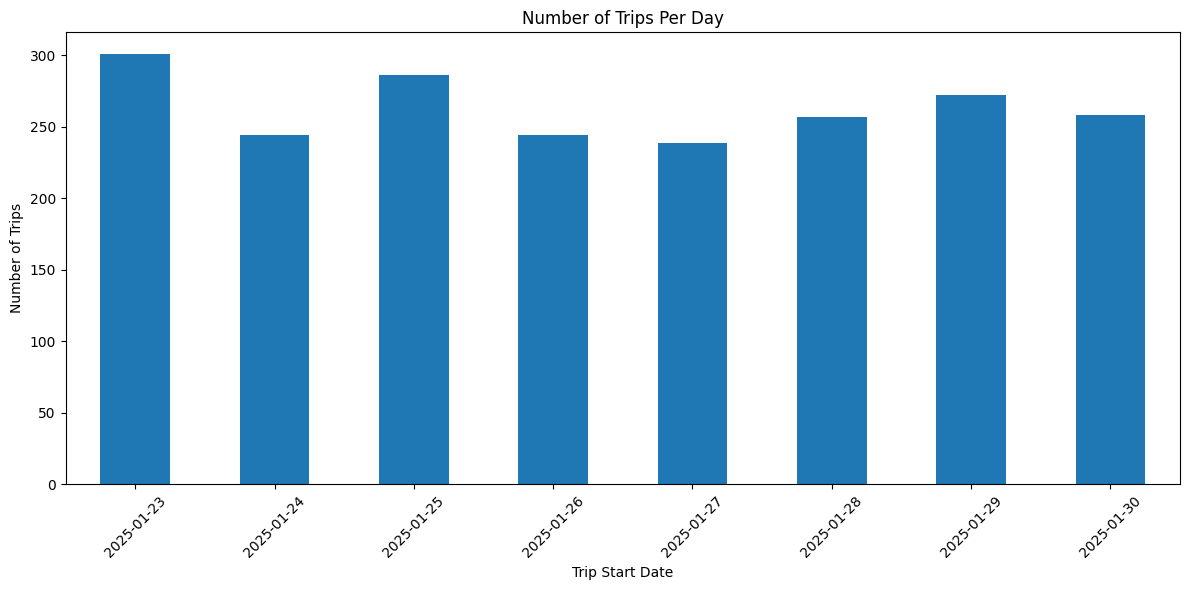

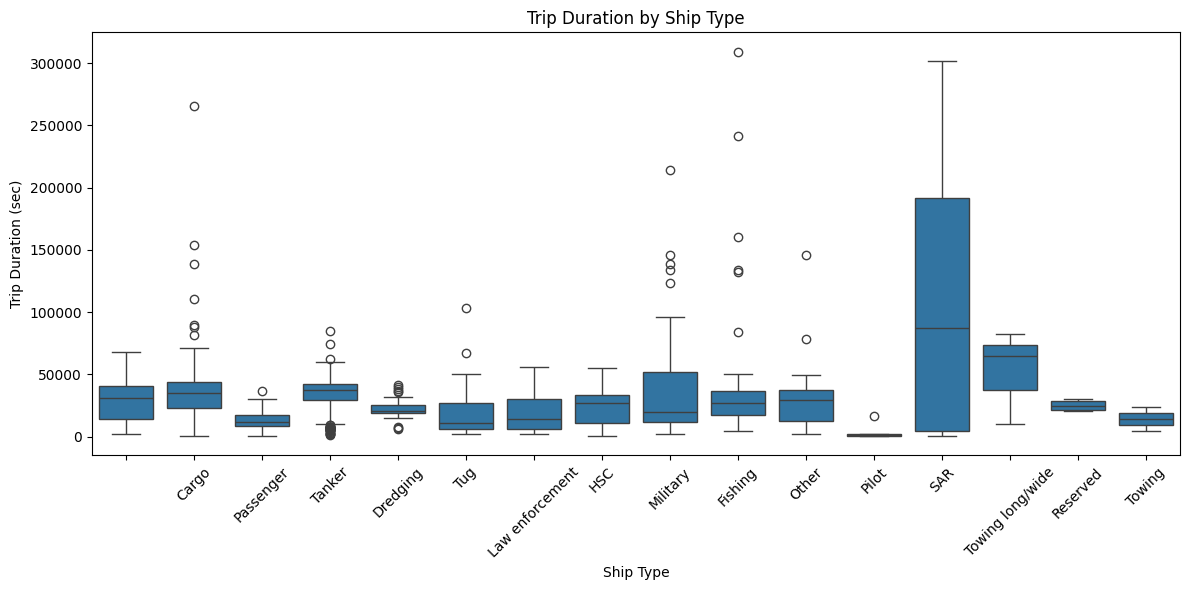

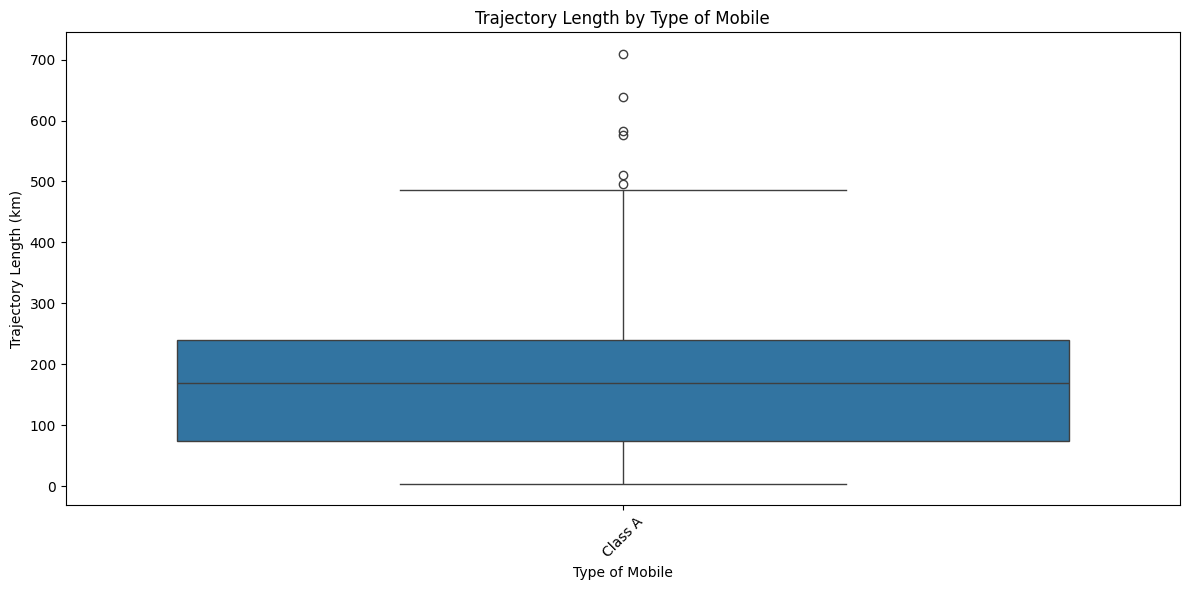

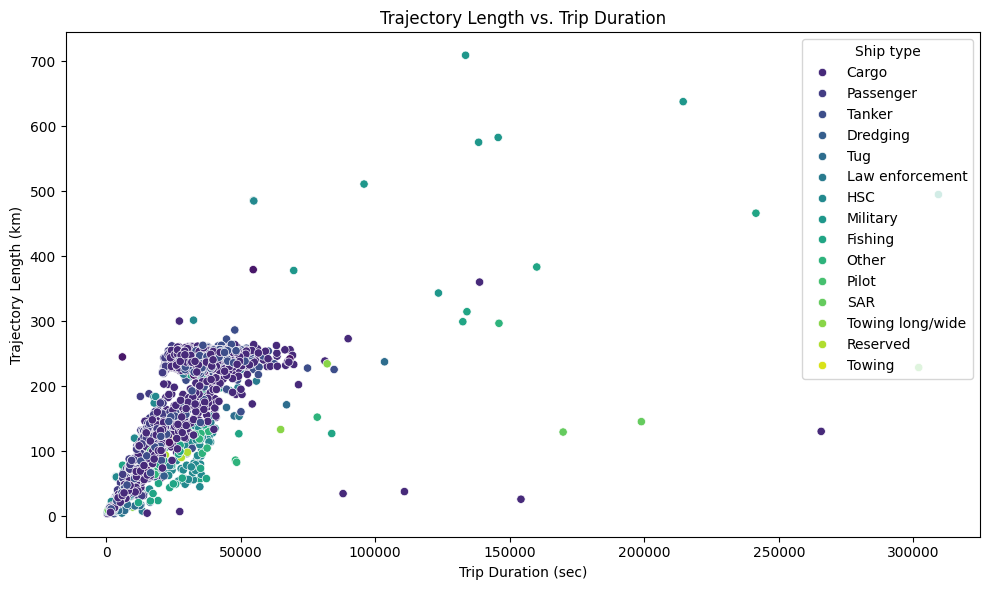

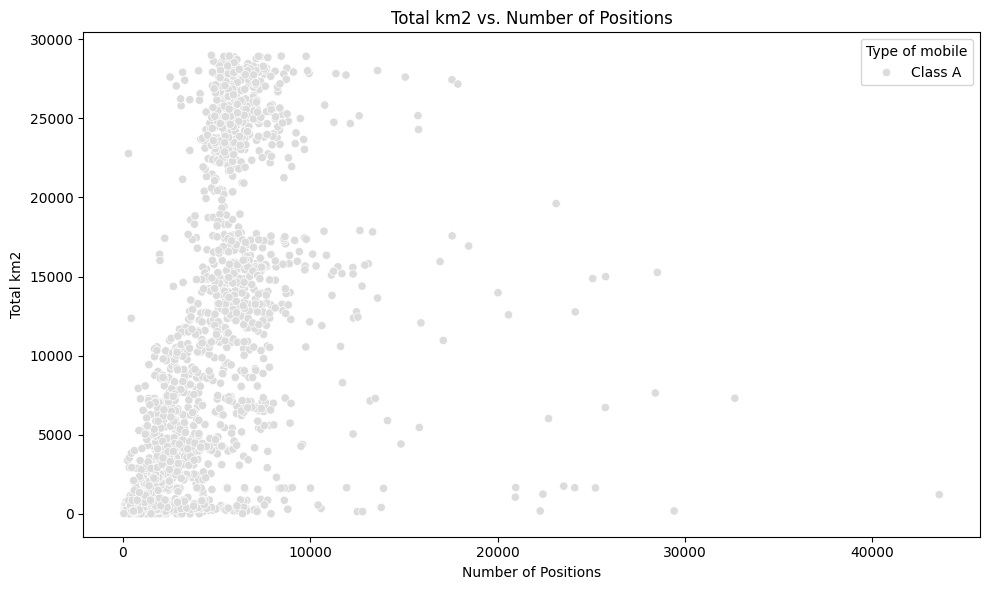

Analysis complete. Review the above plots and tables to explore relationships and distributions in your data.


In [10]:
# %% [code]
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check the first few rows and info about the DataFrame:
print("First 5 rows of the DataFrame:")
display(df.head())
print("\nDataFrame info:")
display(df.info())

# -------------------------------
# 2. Descriptive Statistics
# -------------------------------
# For numerical features, show summary statistics
print("\nSummary statistics for numerical features:")
display(df.describe())

# You can also get a summary for categorical columns, if needed:
print("\nSummary statistics for categorical features:")
display(df.describe(include=['object']))

# -------------------------------
# 3. Visualizing the Distribution of Key Features
# -------------------------------
# Define a list of features you want to analyze.
# (Feel free to add or remove features from this list.)
features = [
    'trip_duration_sec', 'num_positions', 'trajectory_length_km',
    'endpoint_distance_km', 'directness_ratio', 'Shape_Complexity',
    'Bridge_Position_Ratio', 'total_km2'
]

# Plot histograms for the selected numerical features
df[features].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Key Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# -------------------------------
# 4. Correlation Analysis
# -------------------------------
# Compute the correlation matrix for the selected features and plot a heatmap.
corr_matrix = df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Selected Features")
plt.show()

# -------------------------------
# 5. Pairplot for Exploring Relationships
# -------------------------------
# Use seaborn's pairplot to see pairwise relationships between the features.
sns.pairplot(df[features])
plt.suptitle("Pairplot of Selected Features", fontsize=16, y=1.02)
plt.show()

# -------------------------------
# 6. Time Series Analysis: Trips Over Time
# -------------------------------
# Create a new column for the trip start date (without time) and count trips per day.
df['trip_date'] = df['trip_start'].dt.date
trips_per_day = df.groupby('trip_date').size()

plt.figure(figsize=(12, 6))
trips_per_day.plot(kind='bar')
plt.xlabel("Trip Start Date")
plt.ylabel("Number of Trips")
plt.title("Number of Trips Per Day")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# 7. Grouped Analysis by Ship Type (or Type of Mobile)
# -------------------------------
# For example, compare trip duration across different ship types.
plt.figure(figsize=(12, 6))
sns.boxplot(x='Ship type', y='trip_duration_sec', data=df)
plt.title("Trip Duration by Ship Type")
plt.xlabel("Ship Type")
plt.ylabel("Trip Duration (sec)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Similarly, you can analyze other relationships.
# For instance, compare trajectory length by mobile type:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Type of mobile', y='trajectory_length_km', data=df)
plt.title("Trajectory Length by Type of Mobile")
plt.xlabel("Type of Mobile")
plt.ylabel("Trajectory Length (km)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# 8. Additional Analysis: Scatter Plots
# -------------------------------
# Explore the relationship between trip duration and trajectory length.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_duration_sec', y='trajectory_length_km', data=df, hue='Ship type', palette='viridis')
plt.title("Trajectory Length vs. Trip Duration")
plt.xlabel("Trip Duration (sec)")
plt.ylabel("Trajectory Length (km)")
plt.tight_layout()
plt.show()

# Explore the relationship between number of positions and total_km2 covered:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_positions', y='total_km2', data=df, hue='Type of mobile', palette='coolwarm')
plt.title("Total km2 vs. Number of Positions")
plt.xlabel("Number of Positions")
plt.ylabel("Total km2")
plt.tight_layout()
plt.show()

# -------------------------------
# 9. Conclusion / Next Steps
# -------------------------------
print("Analysis complete. Review the above plots and tables to explore relationships and distributions in your data.")



=== ROC AUC SCORES ===

Classifier: SVM Tuned
ROC AUC (one-vs-rest): 0.9477

Classifier: Decision Tree Tuned
ROC AUC (one-vs-rest): 0.9614

Classifier: Random Forest Tuned
ROC AUC (one-vs-rest): 0.9897

=== Calibration Curve for Random Forest (class index 0) ===


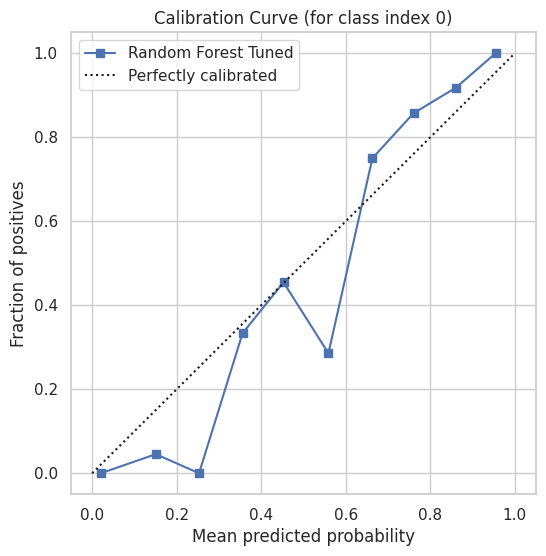


=== Cumulative Gain Chart for SVM (class index 0) ===


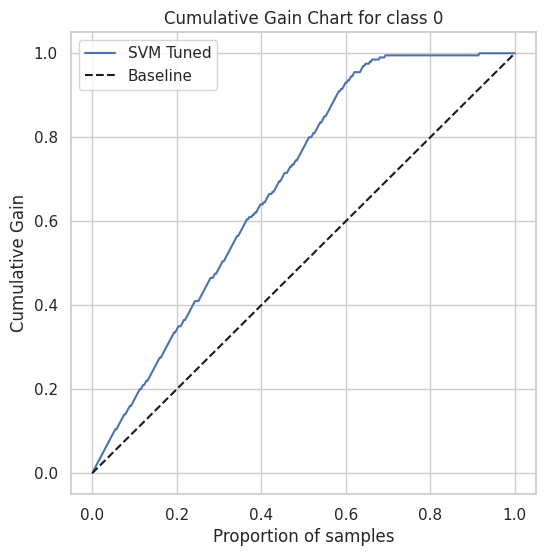


=== Error Analysis Expected Value (using default cost matrix) ===
Confusion Matrix:
 [[192   0   0   3   5]
 [  1  11   0   0   0]
 [  0   0  20   0   0]
 [  1   0   0  82   0]
 [ 23   0   0   0  44]]
Total misclassification cost: 33.0
Expected cost per sample: 0.08638743455497382

=== Fairness Analysis (if applicable) ===
No sensitive attribute found in X_test; skipping fairness analysis.


In [12]:
# =============================================================================
# Additional Evaluation Metrics & Plots
# =============================================================================
# Import necessary modules
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize

# --- Explanation of Additional Metrics ---
# 1. ROC/AUC:
#    - The ROC curve plots the True Positive Rate vs. the False Positive Rate at different thresholds.
#    - The AUC (Area Under the Curve) summarizes the overall ability of the model to discriminate between classes.
#    - For multi-class problems, we compute ROC AUC using a one-vs-rest approach.
#
# 2. Calibration:
#    - Calibration curves (reliability diagrams) show whether predicted probabilities reflect true likelihoods.
#    - A well-calibrated model will have points near the diagonal line (perfect calibration).
#
# 3. Cumulative Gain:
#    - The cumulative gain chart plots the percentage of total positives captured as you move down the ranked list.
#    - This is especially useful for binary (or one-vs-rest) settings where you target a specific class.
#
# 4. Error Analysis Expected Value:
#    - By analyzing the confusion matrix and applying a cost matrix (if available), we can compute the expected cost of misclassifications.
#    - With a default cost (0 for correct, 1 for any error), this is equivalent to the error rate.
#
# 5. Fairness Analysis:
#    - Fairness metrics assess whether the model's performance is similar across different groups.
#    - In our ship classification problem, there is no obvious protected attribute.
#    - The provided placeholder function can be used if you later decide to analyze fairness (for example, by ship flag or size).

# =============================================================================
# Pre-requisites:
# Assume that:
# - X_test and y_test (the true labels) are already defined (from your earlier code).
# - tuned_models is a dictionary containing your tuned classifiers (e.g., from GridSearchCV).
# - y_test is a pandas Series. (Convert to a NumPy array if needed.)
# =============================================================================

y_test_np = y_test.values  # Convert to numpy array if needed

# For ROC AUC in a multi-class scenario, we need to binarize the true labels:
classes = np.unique(y_test_np)
y_test_bin = label_binarize(y_test_np, classes=classes)

# -----------------------
# 1. ROC AUC Calculation
# -----------------------
print("\n=== ROC AUC SCORES ===")
for name, model in tuned_models.items():
    print(f"\nClassifier: {name}")
    # Check if the model can provide probability estimates or decision scores
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        print(f"{name} does not support probability estimates or decision function for ROC AUC calculation.")
        continue
    
    try:
        # Compute ROC AUC using a one-vs-rest approach
        roc_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr')
        print(f"ROC AUC (one-vs-rest): {roc_auc:.4f}")
    except Exception as e:
        print(f"Could not compute ROC AUC for {name}: {e}")

# -------------------------------------
# 2. Calibration Curve (for one chosen class)
# -------------------------------------
print("\n=== Calibration Curve for Random Forest (class index 0) ===")
model_name = "Random Forest Tuned"
if model_name in tuned_models:
    model = tuned_models[model_name]
    if hasattr(model, "predict_proba"):
        # For demonstration, we choose class index 0 (you may choose another class as needed)
        prob_pos = model.predict_proba(X_test)[:, 0]
        # Create binary true labels: 1 if the true label equals 0, else 0
        y_true_class = (y_test_np == 0).astype(int)
        fraction_of_positives, mean_predicted_value = calibration_curve(y_true_class, prob_pos, n_bins=10)
        plt.figure(figsize=(6, 6))
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
        plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        plt.xlabel("Mean predicted probability")
        plt.ylabel("Fraction of positives")
        plt.title("Calibration Curve (for class index 0)")
        plt.legend()
        plt.show()
    else:
        print(f"{model_name} does not support predict_proba for calibration curve.")
else:
    print("Random Forest Tuned model not found in tuned_models.")

# -------------------------------------
# 3. Cumulative Gain Chart (for one chosen class)
# -------------------------------------
def plot_cumulative_gain(y_true_binary, y_proba, model_name="Model", class_label=0):
    """
    Plots the cumulative gain chart for a binary label (one-vs-rest).
    y_true_binary: Binary array (1 if sample belongs to class_label, else 0)
    y_proba: Predicted probabilities (or scores) for class_label.
    """
    data = pd.DataFrame({'y_true': y_true_binary, 'y_proba': y_proba})
    data = data.sort_values(by='y_proba', ascending=False).reset_index(drop=True)
    data['cum_positive'] = data['y_true'].cumsum()
    total_positives = data['y_true'].sum()
    if total_positives == 0:
        print(f"No positive samples for class {class_label}. Cannot plot cumulative gain chart.")
        return
    data['gain'] = data['cum_positive'] / total_positives
    plt.figure(figsize=(6, 6))
    plt.plot(np.arange(1, len(data)+1) / len(data), data['gain'], label=model_name)
    plt.plot([0, 1], [0, 1], "k--", label="Baseline")
    plt.xlabel("Proportion of samples")
    plt.ylabel("Cumulative Gain")
    plt.title(f"Cumulative Gain Chart for class {class_label}")
    plt.legend()
    plt.show()

print("\n=== Cumulative Gain Chart for SVM (class index 0) ===")
model_name = "SVM Tuned"  # Change this if you prefer another model
if model_name in tuned_models:
    model = tuned_models[model_name]
    if hasattr(model, "predict_proba"):
        # Get probability estimates for class index 0
        prob_class = model.predict_proba(X_test)[:, 0]
    elif hasattr(model, "decision_function"):
        # If only decision_function is available, use the raw scores
        prob_class = model.decision_function(X_test)[:, 0]
    else:
        print(f"{model_name} does not support probability estimates for cumulative gain chart.")
        prob_class = None
    if prob_class is not None:
        # Create binary labels for class index 0
        y_true_binary = (y_test_np == 0).astype(int)
        plot_cumulative_gain(y_true_binary, prob_class, model_name=model_name, class_label=0)
else:
    print(f"{model_name} not found in tuned_models.")

# -------------------------------------
# 4. Error Analysis Expected Value via Confusion Matrix
# -------------------------------------
print("\n=== Error Analysis Expected Value (using default cost matrix) ===")
def error_analysis_expected_value(y_true, y_pred, cost_matrix=None):
    """
    Computes the confusion matrix and calculates the total and per-sample misclassification cost.
    If no cost_matrix is provided, a default cost of 1 for any misclassification is used.
    """
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    if cost_matrix is None:
        # Default: cost 0 for correct classification, 1 for any misclassification
        cost_matrix = np.ones(cm.shape) - np.eye(cm.shape[0])
    total_cost = (cm * cost_matrix).sum()
    expected_cost = total_cost / len(y_true)
    print("Total misclassification cost:", total_cost)
    print("Expected cost per sample:", expected_cost)
    return cm, total_cost, expected_cost

# Example: Perform error analysis for the Random Forest Tuned model
if "Random Forest Tuned" in tuned_models:
    model = tuned_models["Random Forest Tuned"]
    y_pred = model.predict(X_test)
    error_analysis_expected_value(y_test_np, y_pred)
else:
    print("Random Forest Tuned model not found in tuned_models.")

# -------------------------------------
# 5. Fairness Analysis Placeholder
# -------------------------------------
print("\n=== Fairness Analysis (if applicable) ===")
# In our ship classification problem, there is no obvious sensitive attribute.
# However, if you later include a feature that is considered sensitive (e.g., 'flag' for nationality),
# you can use the following function to compare group-wise performance.
def fairness_analysis(y_true, y_pred, sensitive_feature):
    """
    Performs a basic group-wise performance analysis.
    sensitive_feature: A pandas Series indicating group membership for each sample.
    """
    df_fair = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'sensitive': sensitive_feature})
    groups = df_fair['sensitive'].unique()
    for group in groups:
        subset = df_fair[df_fair['sensitive'] == group]
        accuracy = np.mean(subset['y_true'] == subset['y_pred'])
        print(f"Sensitive group: {group} - Accuracy: {accuracy:.4f}")

# Example usage:
# If you had a sensitive attribute (say, X_test['flag']), you could run:
if 'flag' in X_test.columns:
    sensitive_attr = X_test['flag']
    if "Random Forest Tuned" in tuned_models:
        model = tuned_models["Random Forest Tuned"]
        y_pred = model.predict(X_test)
        fairness_analysis(y_test_np, y_pred, sensitive_attr)
    else:
        print("Random Forest Tuned model not found for fairness analysis.")
else:
    print("No sensitive attribute found in X_test; skipping fairness analysis.")
